In [1]:
import networkx as nx
from util import graph_from_geojson
from networkx.classes.graph import Graph
import pandas as pd
from typing import Any
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from typing import Literal
import numpy as np

In [ ]:
cze_graph: Graph = graph_from_geojson(r"..\graphs\cze-railroad-network.json")
sk_graph: Graph = graph_from_geojson(r"..\graphs\svk-railroad-network.json")

c:\Program Files\Python313\Lib\site-packages\networkx\readwrite\json_graph\node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


In [6]:

def summary(g: Graph, name: str) -> None:
    # extract maximal component
    max_comp: set[str] = max(nx.connected_components(g), key=len)
    G_0: Graph = g.subgraph(max_comp)

    print(f"Statistics for {name}: ")
    # components
    print(f"number of components: {nx.number_connected_components(g)}")
    # total # of nodes and edges
    print(f"Number of all nodes and edges: nodes -> {g.number_of_nodes()}, edges -> {g.number_of_edges()}")
    # of nodes and edges in maximal component
    print(f"Number of nodes and edges in maximal component: nodes -> {G_0.number_of_nodes()}, edges -> {G_0.number_of_edges()}")

    # from now on, deal with only maximal component
    print(f"average degree: {(2*G_0.number_of_edges()) / G_0.number_of_nodes()}")
    print(f"density: {nx.density(G_0)}")

    print(f"diameter: {nx.diameter(G_0, weight="distance")}")

    print(f"riadus: {nx.radius(G_0, weight="distance")}")
    
    print('################')

for g, name in zip((cze_graph, sk_graph), ("czechia","slovakia")):
    summary(g, name)


Statistics for czechia: 
number of components: 35
Number of all nodes and edges: nodes -> 1146, edges -> 1262
Number of nodes and edges in maximal component: nodes -> 1108, edges -> 1258
average degree: 2.270758122743682
density: 0.002051272016931962
diameter: 613006.2012869688
riadus: 311126.43599004054
################
Statistics for slovakia: 
number of components: 6
Number of all nodes and edges: nodes -> 426, edges -> 449
Number of nodes and edges in maximal component: nodes -> 421, edges -> 449
average degree: 2.133016627078385
density: 0.005078611016853297
diameter: 562680.7286815441
riadus: 282189.15028555173
################


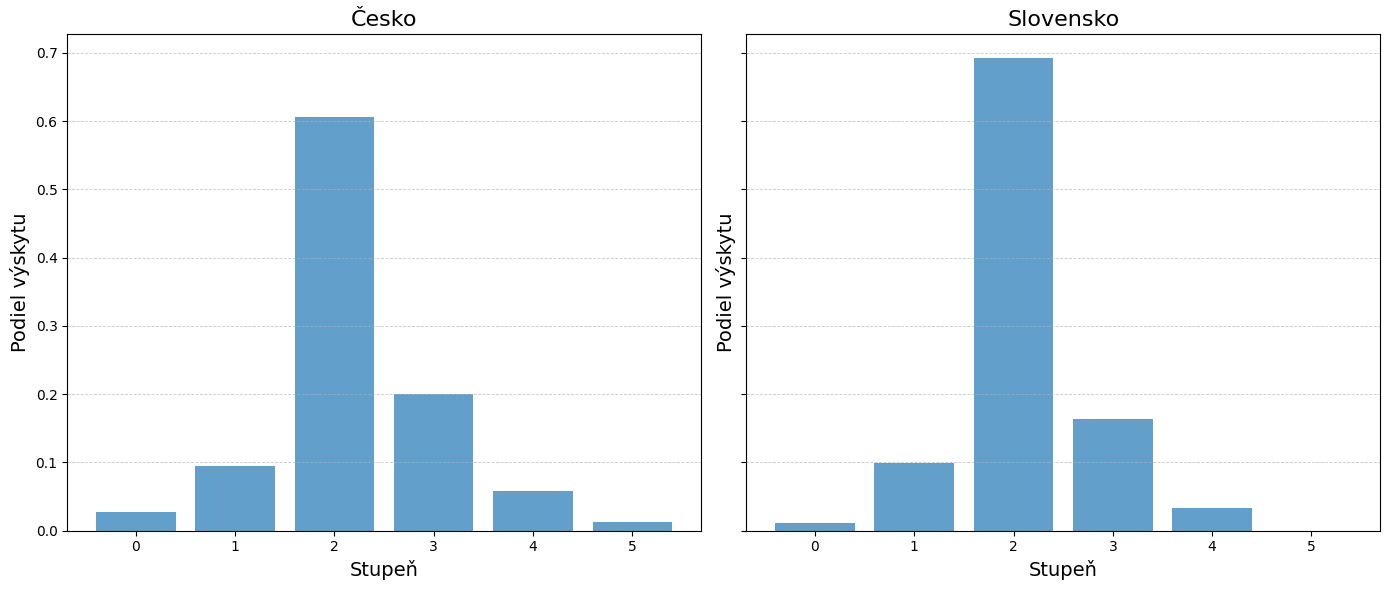

In [ ]:
deg_cze = [d for _, d in cze_graph.degree()]
deg_svk = [d for _, d in sk_graph.degree()]

# max degree in both countries
max_deg = max(max(deg_cze), max(deg_svk))

# bins from -0.5 to max_deg+0.5 -> middles in 0,1,2,...
bins = np.arange(-0.5, max_deg + 1.5, 1)

fig, axes = plt.subplots(ncols=2, figsize=(14, 6), sharey=True)

for ax, degrees, title in zip(axes, [deg_cze, deg_svk], ['Česko', 'Slovensko']):
    weights = np.ones_like(degrees) / len(degrees)
    ax.hist(degrees,
            bins=bins,
            weights=weights,
            alpha=0.7,
            rwidth=0.8,      # relative width of the columns (0<rwidth≤1)
            align='mid')     # align to the middle of the bins
    ax.set_title(f'{title}', fontsize=16)
    ax.set_xlabel('Stupeň', fontsize=14)
    ax.set_ylabel('Podiel výskytu', fontsize=14)
    ax.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.7)
    # integers xticks
    ax.set_xticks(range(0, max_deg + 1))

fig.tight_layout()
plt.show()

In [4]:
def centrality(sk_graph: Graph, cze_graph: Graph,
               kind: Literal["eigen", "page", "katz", "local_cluster", "betweeness"],
               save_path: str, show: bool = False) -> None:
    
    match kind:
        case "eigen":
            dc_cze = nx.eigenvector_centrality(cze_graph, max_iter=1_000)
            dc_svk = nx.eigenvector_centrality(sk_graph, max_iter=1_000)
            color_bar = "Eigenvector centrality"
        case "katz":
            vals = nx.adjacency_spectrum(cze_graph)
            lambda_max = max(abs(v) for v in vals)
            alpha = 0.8 / lambda_max   # use, say, 80% of the threshold
            dc_cze = nx.katz_centrality(
                cze_graph,
                alpha=alpha,
                beta=1.0,   
                max_iter=1_000,
                tol=1e-6)

            vals = nx.adjacency_spectrum(sk_graph)
            lambda_max = max(abs(v) for v in vals)
            alpha = 0.8 / lambda_max 
            dc_svk = nx.katz_centrality(
                sk_graph,
                alpha=alpha,
                beta=1.0,
                max_iter=1_000,
                tol=1e-6)
            color_bar = "Katzova centralita"
        case "page":
            dc_cze = nx.pagerank(cze_graph, alpha=0.95, max_iter=1000, tol=1e-6)
            dc_svk = nx.pagerank(sk_graph,  alpha=0.95, max_iter=1000, tol=1e-6)
            color_bar = "Page rank centrality"
        case "local_cluster":
            dc_cze = nx.clustering(cze_graph)
            dc_svk = nx.clustering(sk_graph)
            color_bar = "Local cluster coeficients"
        case "betweeness":
            dc_cze = nx.betweenness_centrality(cze_graph, weight="distance")
            dc_svk = nx.betweenness_centrality(sk_graph, weight="distance")
            color_bar = "Centralita prepojenosti"

    # 1. Build node GeoDataFrames
    df_nodes_svk = pd.DataFrame([
        {'node': n, 'eigen': dc_svk[n], 'geometry': attrs['geometry']}
        for n, attrs in sk_graph.nodes(data=True)
    ])
    gdf_nodes_svk = gpd.GeoDataFrame(df_nodes_svk, geometry='geometry', crs="EPSG:4326")

    df_nodes_cze = pd.DataFrame([
        {'node': n, 'eigen': dc_cze[n], 'geometry': attrs['geometry']}
        for n, attrs in cze_graph.nodes(data=True)
    ])
    gdf_nodes_cze = gpd.GeoDataFrame(df_nodes_cze, geometry='geometry', crs="EPSG:4326")

    # 2. Build edge GeoDataFrames
    edges_cze = [
        attrs['geometry'] for u, v, attrs in cze_graph.edges(data=True)
        if 'geometry' in attrs
    ]
    gdf_edges_cze = gpd.GeoDataFrame(geometry=edges_cze, crs="EPSG:4326")

    edges_svk = [
        attrs['geometry'] for u, v, attrs in sk_graph.edges(data=True)
        if 'geometry' in attrs
    ]
    gdf_edges_svk = gpd.GeoDataFrame(geometry=edges_svk, crs="EPSG:4326")

    # 3. Extract coords & centralities
    lon_cze = gdf_nodes_cze.geometry.x
    lat_cze = gdf_nodes_cze.geometry.y
    eig_cze = gdf_nodes_cze['eigen']
    text_cze = gdf_nodes_cze['node']

    lon_svk = gdf_nodes_svk.geometry.x
    lat_svk = gdf_nodes_svk.geometry.y
    eig_svk = gdf_nodes_svk['eigen']
    text_svk = gdf_nodes_svk['node']

    # 4. Shared color scale
    min_eig = min(eig_cze.min(), eig_svk.min())
    max_eig = max(eig_cze.max(), eig_svk.max())

    # 5. Helper to flatten edges
    def flatten_edges(gdf_edges):
        lon, lat = [], []
        for line in gdf_edges.geometry:
            xs, ys = line.xy
            lon += list(xs) + [None]
            lat += list(ys) + [None]
        return lon, lat

    edge_lon_cze, edge_lat_cze = flatten_edges(gdf_edges_cze)
    edge_lon_svk, edge_lat_svk = flatten_edges(gdf_edges_svk)

    # 6. Build Plotly figure
    fig = go.Figure()

    # 6a. Track layers (gray lines)
    fig.add_trace(go.Scattermap(
        lon=edge_lon_cze, lat=edge_lat_cze, mode='lines',
        line=dict(width=0.5, color='gray'), hoverinfo='none', name='Czech Tracks'
    ))
    fig.add_trace(go.Scattermap(
        lon=edge_lon_svk, lat=edge_lat_svk, mode='lines',
        line=dict(width=0.5, color='gray'), hoverinfo='none', name='Slovak Tracks'
    ))

    # 6b. Station layers (shared coloraxis)
    fig.add_trace(go.Scattermap(
        lon=lon_cze, lat=lat_cze, mode='markers',
        marker=dict(size=6, color=eig_cze, coloraxis='coloraxis'),
        text=text_cze, hovertemplate='%{text}<br>Eigen: %{marker.color:.3f}<extra></extra>',
        name='Czech Stations'
    ))
    fig.add_trace(go.Scattermap(
        lon=lon_svk, lat=lat_svk, mode='markers',
        marker=dict(size=6, color=eig_svk, coloraxis='coloraxis'),
        text=text_svk, hovertemplate='%{text}<br>Eigen: %{marker.color:.3f}<extra></extra>',
        name='Slovak Stations'
    ))

    # 7. Layout & shared colorbar
    fig.update_layout(
        mapbox_style="open-street-map",
        mapbox_zoom=6,
        mapbox_center={
            "lat": float((lat_cze.mean() + lat_svk.mean()) / 2),
            "lon": float((lon_cze.mean() + lon_svk.mean()) / 2)
        },
        coloraxis=dict(
            colorscale='Inferno',
            cmin=min_eig, cmax=max_eig,
            colorbar=dict(title=color_bar)
        ),
        margin=dict(l=0, r=0, t=30, b=0),
        legend=dict(yanchor='top', y=0.99, xanchor='left', x=0.01),
        showlegend=False
    )

    if show:
        fig.show()

    fig.write_html(f"{save_path}", include_plotlyjs='cdn')


In [5]:
centrality(sk_graph, cze_graph, kind="eigen", save_path=r"visualizations\eigenvector_map.html", show=True)

In [ ]:
centrality(sk_graph, cze_graph, kind="local_cluster", save_path="visualizations/local_cluster.html")


In [6]:
centrality(sk_graph, cze_graph, kind="betweeness", save_path="visualizations/betweeness.html")

In [ ]:
centrality(sk_graph, cze_graph, kind="eigen", save_path="visualizations/eigen.html")

In [ ]:
centrality(sk_graph, cze_graph, kind="page", save_path="visualizations/page_rank_map.html")

In [ ]:
centrality(sk_graph, cze_graph, kind="katz", save_path="visualizations/katz.html")

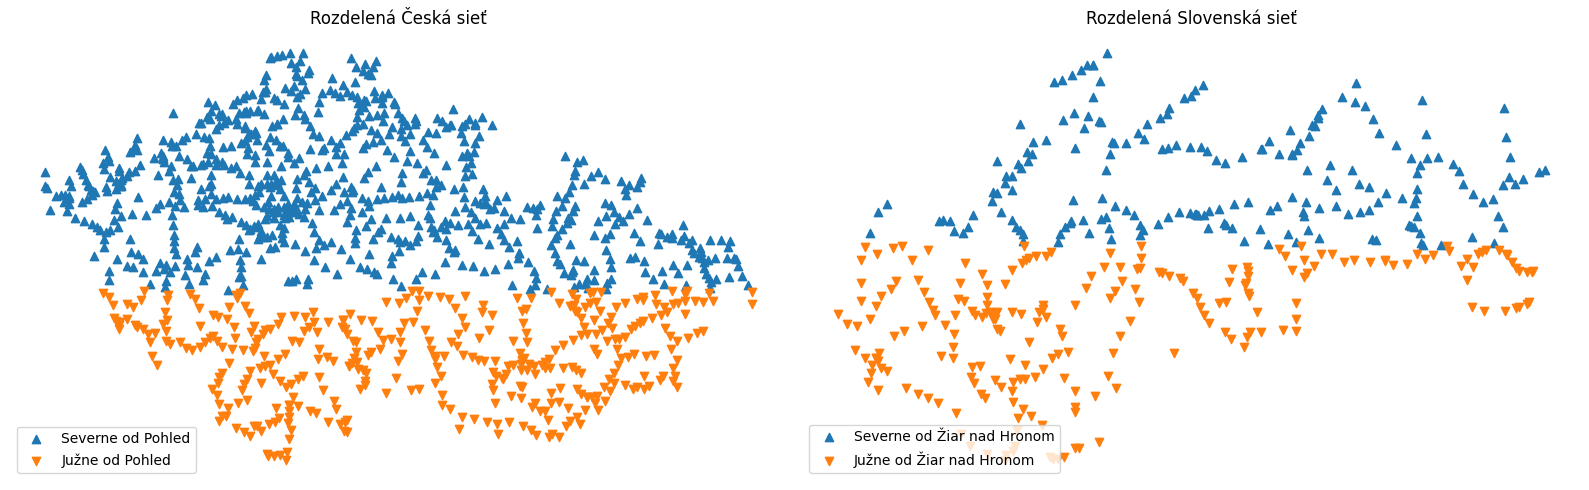

In [ ]:
# define north/south split
def split_north_south(G: Graph, pivot: str) -> list[str]:
    pivot_lat: float = G.nodes[pivot]['geometry'].y
    north: list[str] = [n for n, d in G.nodes(data=True) if d['geometry'].y > pivot_lat]
    south: list[str] = [n for n, d in G.nodes(data=True) if d['geometry'].y <= pivot_lat]
    return north, south

# create side-by-side figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), sharex=False, sharey=False)

# Czechia on the left
north_cz, south_cz = split_north_south(cze_graph, "Pohled")
ax1.scatter(
    [cze_graph.nodes[n]['geometry'].x for n in north_cz],
    [cze_graph.nodes[n]['geometry'].y for n in north_cz],
    marker='^', label='Severne od Pohled'
)
ax1.scatter(
    [cze_graph.nodes[n]['geometry'].x for n in south_cz],
    [cze_graph.nodes[n]['geometry'].y for n in south_cz],
    marker='v', label='Južne od Pohled'
)
ax1.set_title("Rozdelená Česká sieť")
ax1.set_axis_off()
ax1.legend(loc='lower left')

# Slovakia on the right
north_sk, south_sk = split_north_south(sk_graph, "Vlkanová")
ax2.scatter(
    [sk_graph.nodes[n]['geometry'].x for n in north_sk],
    [sk_graph.nodes[n]['geometry'].y for n in north_sk],
    marker='^', label='Severne od Žiar nad Hronom'
)
ax2.scatter(
    [sk_graph.nodes[n]['geometry'].x for n in south_sk],
    [sk_graph.nodes[n]['geometry'].y for n in south_sk],
    marker='v', label='Južne od Žiar nad Hronom'
)
ax2.set_title("Rozdelená Slovenská sieť")
ax2.set_axis_off()
ax2.legend(loc='lower left')

plt.tight_layout()
plt.show()


In [65]:
labeling_cze: dict[str, str] = {n: "north" for n in north_cz}
labeling_cze.update({n: "south" for n in south_cz})
labeling_sk: dict[str, str] = {n: "north" for n in north_sk}
labeling_sk.update({n: "south" for n in south_sk})
nx.set_node_attributes(cze_graph, labeling_cze, name="direction")
nx.set_node_attributes(sk_graph, labeling_sk, name="direction")


In [66]:
print(nx.attribute_assortativity_coefficient(cze_graph, attribute="direction"))
print(nx.attribute_assortativity_coefficient(sk_graph, attribute="direction"))

0.9607453907928969
0.9013344520356387


## Not used exploration

In [12]:
def group_report(G: Graph, attr: str = 'direction') -> None:
    groups = set(nx.get_node_attributes(G,attr).values())
    for g in groups:
        Gg = G.subgraph([n for n,d in G.nodes(data=True) if d[attr]==g])
        print(f"=== {g.upper()} ===")
        print(" Nodes:", Gg.number_of_nodes(),
              "Edges:", Gg.number_of_edges(),
              "Density:", round(nx.density(Gg),3))
        print(" Global zhluk. koef:", round(nx.transitivity(Gg),3))

group_report(cze_graph)
print('################')
group_report(sk_graph)
    

=== NORTH ===
 Nodes: 750 Edges: 831 Density: 0.003
 Global zhluk. koef: 0.087
=== SOUTH ===
 Nodes: 396 Edges: 409 Density: 0.005
 Global zhluk. koef: 0.027
################
=== NORTH ===
 Nodes: 198 Edges: 195 Density: 0.01
 Global zhluk. koef: 0.026
=== SOUTH ===
 Nodes: 228 Edges: 232 Density: 0.009
 Global zhluk. koef: 0.03


In [13]:
from networkx.algorithms.community import modularity
north, south = split_north_south(cze_graph, "Pohled")

# define your partition as a list of node-sets (or lists)
partition: list[set[str]] = [set(north), set(south)]

Q: float = modularity(cze_graph, partition, weight='weight')
print(f"Modularity of north/south split: {Q:.4f}")


north, south = split_north_south(sk_graph, "Vlkanová")

# define your partition as a list of node-sets (or lists)
partition = [set(north), set(south)]

Q = modularity(sk_graph, partition, weight='weight')
print(f"Modularity of north/south split: {Q:.4f}")

Modularity of north/south split: 0.4267
Modularity of north/south split: 0.4476


c:\Users\antal\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\plotting.py:956: UserWarning:

constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.

c:\Users\antal\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\plotting.py:956: UserWarning:

constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.

C:\Users\antal\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning:

constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.



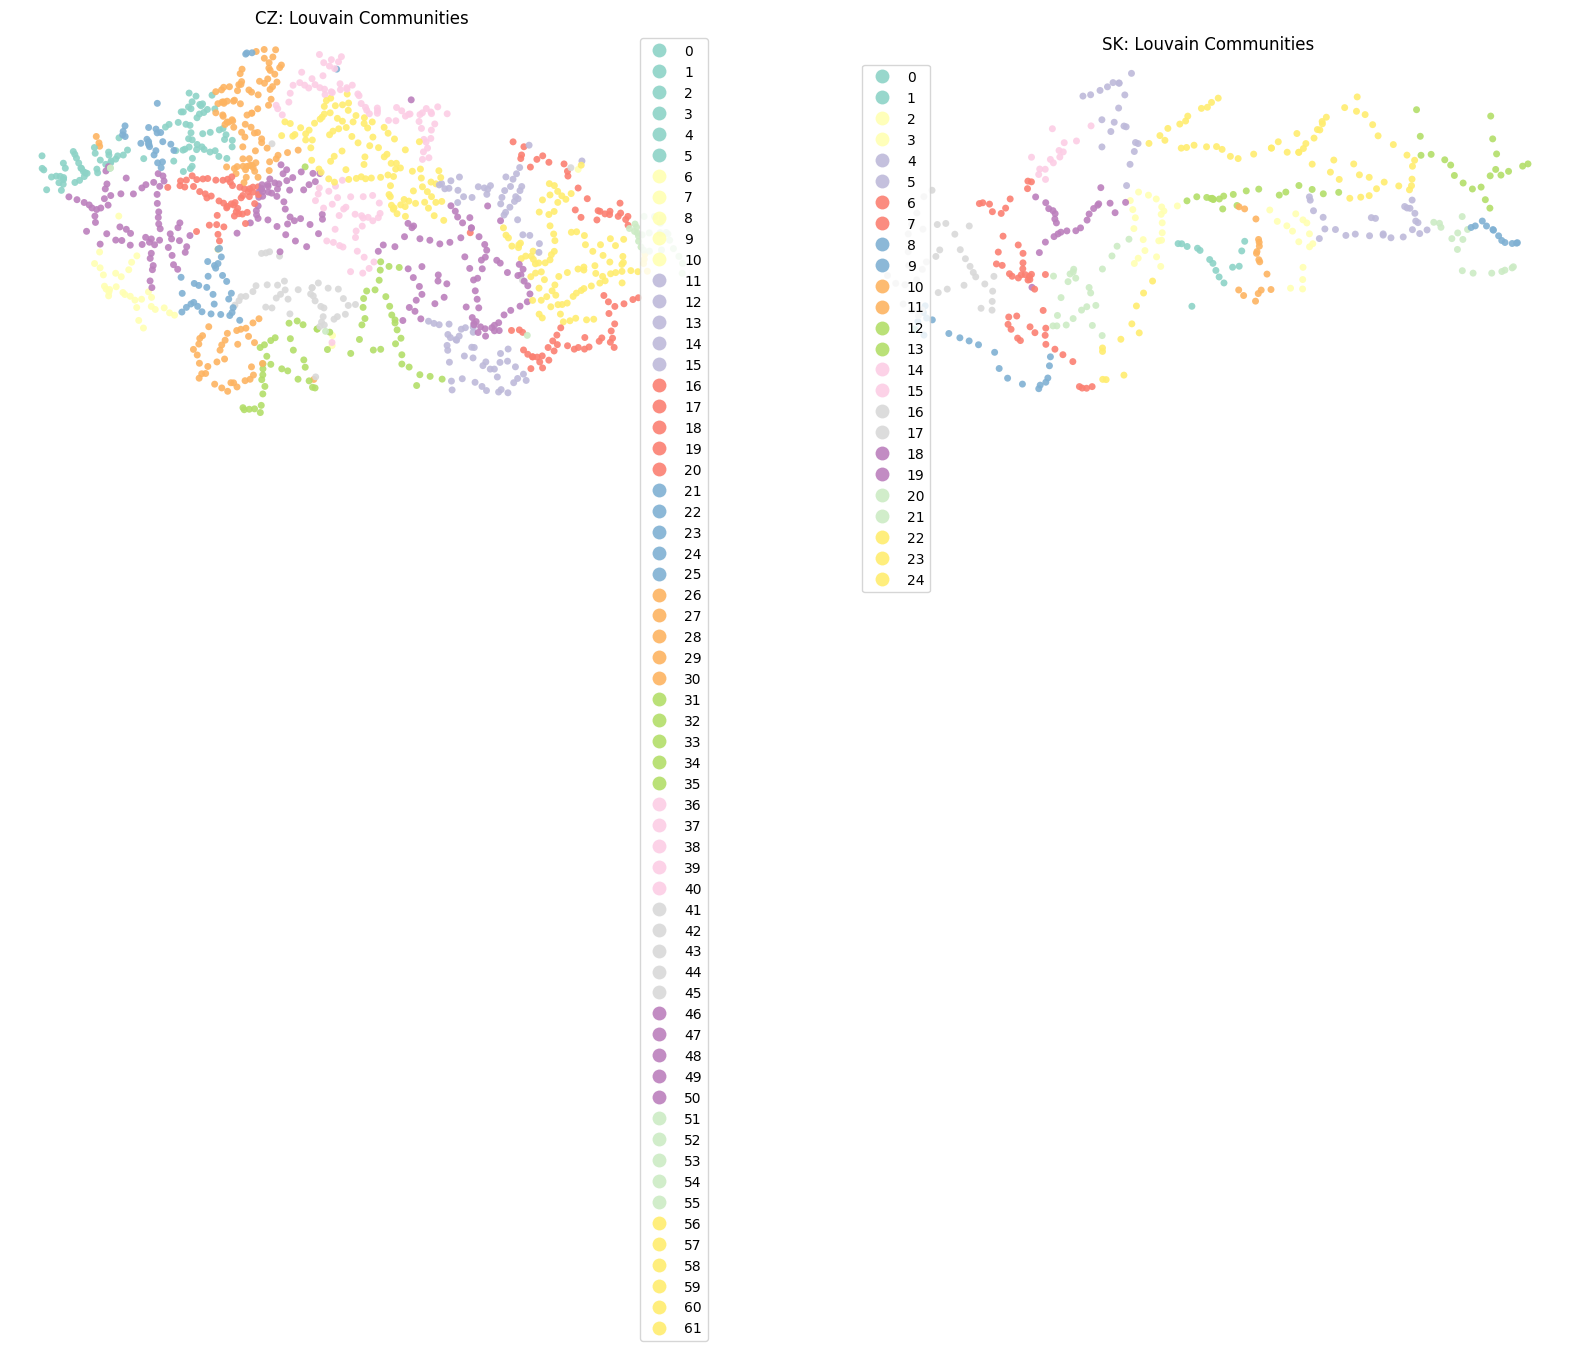

In [ ]:
from networkx.algorithms.community import louvain_communities

communities_cz: list = louvain_communities(cze_graph, seed=42, resolution=1)
community_map_cz: dict = {n: cid for cid, com in enumerate(communities_cz) for n in com}
nx.set_node_attributes(cze_graph, community_map_cz, "community")

communities_sk: list = louvain_communities(sk_graph, seed=42, resolution=1)
community_map_sk: dict = {n: cid for cid, com in enumerate(communities_sk) for n in com}
nx.set_node_attributes(sk_graph, community_map_sk, "community")

def build_gdf(G) -> gpd.GeoDataFrame:
    records = []
    for n, data in G.nodes(data=True):
        # skip nodes without geometry
        if "geometry" not in data:
            continue
        records.append({
            "id": n,
            "community": data["community"],
            "geometry": data["geometry"],
        })
    return gpd.GeoDataFrame(records, crs="EPSG:4326", geometry="geometry")

gdf_cz = build_gdf(cze_graph)
gdf_sk = build_gdf(sk_graph)

fig, axes = plt.subplots(1, 2, figsize=(20, 8), constrained_layout=True)

# Czech map
gdf_cz.plot(
    ax=axes[0],
    column="community",
    categorical=True,
    legend=True,
    cmap="Set3",
    markersize=25,
    alpha=0.9,
    linewidth=0,
)
axes[0].set_title("CZ: Louvain Communities")
axes[0].set_axis_off()

# Slovak map
gdf_sk.plot(
    ax=axes[1],
    column="community",
    categorical=True,
    legend=True,
    cmap="Set3",
    markersize=25,
    alpha=0.9,
    linewidth=0,
)
axes[1].set_title("SK: Louvain Communities")
axes[1].set_axis_off()

plt.show()